# Effect of exchange rate on production in manufacturing and government

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`
pd.set_option('display.float_format', lambda x: '%.2f' % x) # formating
from matplotlib.dates import date2num

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

**We import data from Statistics Denmark regarding production divided between industries and data regarding the effective exchange rate of the DKK**

In [279]:
GDP = DstApi('NKBP10')
EXRATE = DstApi('DNVALQ') 

# a. Tables of the variables
tabsum_GDP = GDP.tablesummary(language='en')
display(tabsum_GDP)
tabsum_EXRATE = EXRATE.tablesummary(language='en')
display(tabsum_EXRATE)


Table NKBP10: 1-2.1.1 Production
and  generation of income (10a3-grouping) by transaction, industry, price unit, seasonal adjustment and time
Last update: 2023-03-31T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TRANSAKT,7,P1K,P.1 Output,B2A3GD,B.2g+B.3g Gross operating surplus and mixed in...,False
1,BRANCHE,15,V,Total,VR_S,"R_S Arts, entertainment and other services",False
2,PRISENHED,2,V,Current prices,LKV,"2010-prices, chained values",False
3,SÆSON,2,N,Non-seasonally adjusted,Y,Seasonally adjusted,False
4,Tid,132,1990K1,1990Q1,2022K4,2022Q4,True


Table DNVALQ: Quarterly exchange rates by currency, type, methodology and time
Last update: 2023-03-30T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,VALUTA,2,DKK,Nominal effective Krone rate (Jan. 1970-),X00,All currencies - excl. Danish kroner,False
1,KURTYP,4,INX,"Index (only nominal effective krone rate), ind...",RET,Real effective krone rate based on hourly earn...,False
2,OPGOER,3,A,Quarterly average,Y,Annual growth rate,False
3,Tid,212,1970K1,1970Q1,2022K4,2022Q4,True


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

In [280]:
# The available values for each variable in GDP dataset: 
for variable in tabsum_GDP['variable name']:
    print(variable+':')
    display(GDP.variable_levels(variable, language='en'))

TRANSAKT:


,id,text
0,P1K,P.1 Output
1,P2D,P.2 Intermediate consumption
2,B1GD,B.1g Gross value added
3,D29X39D,D.29-D.39 Other taxes less subsidies on produc...
4,B1GFD,B.1GF Gross domestic product at factor cost
5,D1D,D.1 Compensation of employees
6,B2A3GD,B.2g+B.3g Gross operating surplus and mixed in...


BRANCHE:


,id,text
0,V,Total
1,VMEMO,Of which: General government
2,VA,"A Agriculture, forestry and fishing"
3,VB,B Mining and quarrying
4,VC,C Manufacturing
5,VD_E,D_E Utility services
6,VF,F Construction
7,VG_I,G_I Trade and transport etc.
8,VJ,J Information and communication
9,VK,K Financial and insurance


PRISENHED:


,id,text
0,V,Current prices
1,LKV,"2010-prices, chained values"


SÆSON:


,id,text
0,N,Non-seasonally adjusted
1,Y,Seasonally adjusted


Tid:


,id,text
0,1990K1,1990Q1
1,1990K2,1990Q2
2,1990K3,1990Q3
3,1990K4,1990Q4
4,1991K1,1991Q1
...,...,...
127,2021K4,2021Q4
128,2022K1,2022Q1
129,2022K2,2022Q2
130,2022K3,2022Q3


In [281]:
# The available values for each variable in exchange rate dataset: 
for variable in tabsum_EXRATE['variable name']:
    print(variable+':')
    display(EXRATE.variable_levels(variable, language='en'))

VALUTA:


,id,text
0,DKK,Nominal effective Krone rate (Jan. 1970-)
1,X00,All currencies - excl. Danish kroner


KURTYP:


,id,text
0,INX,"Index (only nominal effective krone rate), ind..."
1,LOI,"Hourly earnings in manufacturing in Denmark, s..."
2,LOU,Weighted hourly earnings in manufacturing abro...
3,RET,Real effective krone rate based on hourly earn...


OPGOER:


,id,text
0,A,Quarterly average
1,B,Calculated
2,Y,Annual growth rate


Tid:


,id,text
0,1970K1,1970Q1
1,1970K2,1970Q2
2,1970K3,1970Q3
3,1970K4,1970Q4
4,1971K1,1971Q1
...,...,...
207,2021K4,2021Q4
208,2022K1,2022Q1
209,2022K2,2022Q2
210,2022K3,2022Q3


**Defining parameters, joining and filtering data**

In [282]:
# a. define parameters
params_GDP = GDP._define_base_params(language='en')
params_EXRATE = EXRATE._define_base_params(language='en')

# b. load api
GDP_api = GDP.get_data(params=params_GDP)
EXRATE_api = EXRATE.get_data(params=params_EXRATE)

In [296]:
# a. left join data by TID
api = pd.merge(GDP_api, EXRATE_api, on='TID', how='left')
api.rename(columns = {'INDHOLD_x':'GDP', 'INDHOLD_y':'EXRATE'}, inplace=True)

# b. filter data
I = api.TRANSAKT.str.contains('P.1')
I &= api.PRISENHED.str.contains('Current prices')
I &= api.SÆSON.str.contains('Seasonally adjusted')
I &= api.VALUTA.str.contains('Nominal effective')
I &= api.KURTYP.str.contains('Index')
I &= api.OPGOER.str.contains('Quarterly')
I &= api.TID.str.contains('Q1')
api.loc[I, :]
api = api.loc[I == True]

# c. new indexing and atomic types
api.reset_index(inplace = True, drop = True)
api = api.apply(pd.to_numeric, errors='ignore')
api['TID'] = api['TID'].apply(pd.to_datetime, errors='ignore')

# d. show data
api.head(5)

,TRANSAKT,BRANCHE,PRISENHED,SÆSON,TID,GDP,VALUTA,KURTYP,OPGOER,EXRATE
0,P.1 Output,Total,Current prices,Seasonally adjusted,2016-01-01,894048,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.21
1,P.1 Output,"A Agriculture, forestry and fishing",Current prices,Seasonally adjusted,2016-01-01,19179,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.21
2,P.1 Output,B Mining and quarrying,Current prices,Seasonally adjusted,2016-01-01,6223,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.21
3,P.1 Output,C Manufacturing,Current prices,Seasonally adjusted,2016-01-01,177829,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.21
4,P.1 Output,D_E Utility services,Current prices,Seasonally adjusted,2016-01-01,21661,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.21


# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

In [297]:
# a. descriptive statistics grouped by industries
api.groupby(by=['BRANCHE'])['GDP'].describe()

,count,mean,std,min,25%,50%,75%,max
BRANCHE,,,,,,,,
"A Agriculture, forestry and fishing",33.00,17966.70,2796.50,14462.00,15971.00,16783.00,20737.00,25110.00
B Mining and quarrying,33.00,8610.79,5191.32,2412.00,3603.00,8171.00,12848.00,20516.00
C Manufacturing,33.00,143618.00,38458.92,89699.00,112730.00,137769.00,168562.00,231198.00
D_E Utility services,33.00,18060.39,5945.57,8489.00,12832.00,19790.00,21873.00,33924.00
F Construction,33.00,49044.48,18245.17,23319.00,36156.00,48351.00,60389.00,92423.00
G_I Trade and transport etc.,33.00,160834.12,66629.13,72380.00,102155.00,159708.00,206939.00,344282.00
J Information and communication,33.00,32094.27,13327.77,11702.00,19944.00,35007.00,40427.00,55943.00
K Financial and insurance,33.00,31365.67,11689.40,14826.00,19834.00,31495.00,41892.00,51294.00
LA Real estate activities and renting of non-residential buildings,33.00,14013.09,6060.96,5326.00,8580.00,14595.00,17750.00,26765.00


Plotting manufacturing and government against the effective exchange rate

Text(0.5, 1.0, 'Production in the manufacturing and government sectors')

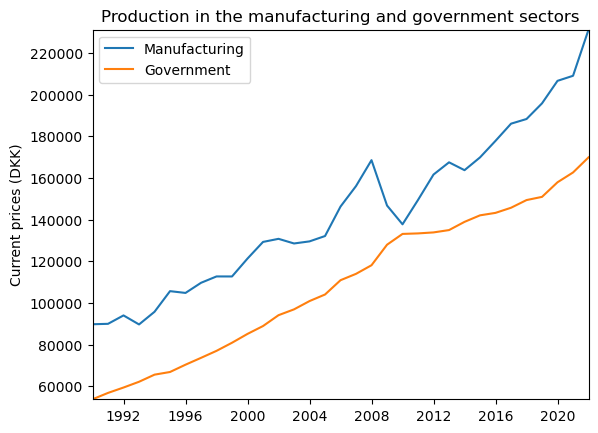

In [304]:
# a. sort values by time
api = api.sort_values(by='TID',ascending=True)

# b. define data to graph
man_plot = api.loc[api.BRANCHE.str.contains('Manufacturing') == True]
gov_plot = api.loc[api.BRANCHE.str.contains('Public administration, education and health') == True]

# c. plot in one graph
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(man_plot['TID'],man_plot['GDP'],label='Manufacturing')
ax.plot(gov_plot['TID'],gov_plot['GDP'],label='Government')
ax.margins(0,0)
ax.legend()
plt.ylabel('Current prices (DKK)')
plt.title('Production in the manufacturing and government sectors')

C:\Users\jacob\AppData\Local\Temp\ipykernel_11776\2475842208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_plot['Diff'] = man_plot['GDP'].diff(periods=1)
C:\Users\jacob\AppData\Local\Temp\ipykernel_11776\2475842208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gov_plot['Diff'] = gov_plot['GDP'].diff(periods=1)


Text(0, 0.5, 'index=100, january 1970')

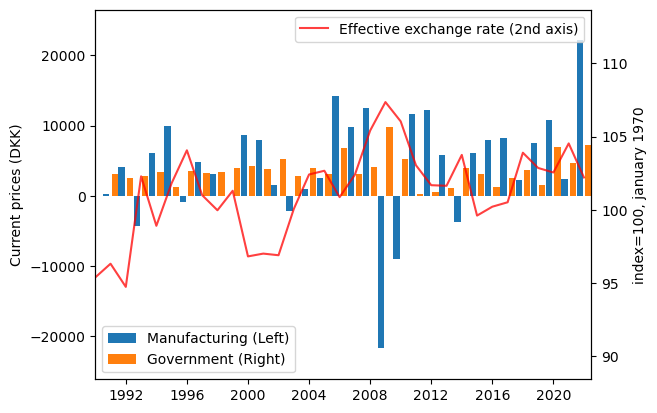

In [315]:
# a. calculating differences
man_plot['Diff'] = man_plot['GDP'].diff(periods=1)
gov_plot['Diff'] = gov_plot['GDP'].diff(periods=1)

# b. define empty plot with two axes
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twinx()

# c. plot the differences as bars and the exchange rate as a line
ax1.bar(height=man_plot['Diff'],x=date2num(man_plot['TID'])-100,width=150,label='Manufacturing (Left)')
ax1.bar(height=gov_plot['Diff'],x=date2num(gov_plot['TID'])+100,width=150,label='Government (Right)')
ax2.plot(date2num(man_plot['TID']),man_plot['EXRATE'],color='red',alpha=0.75, label='Effective exchange rate (2nd axis)')
ax1.xaxis_date()

# d. formatting
ax1.legend(loc=0)
ax2.legend(loc=0)
ax1.margins(0,0.1)
ax2.margins(0,0.5)
ax1.set_ylabel('Current prices (DKK)')
ax2.set_ylabel('index=100, january 1970')

# Conclusion

ADD CONCISE CONLUSION.